### **🧩 Adım 0 — Yol ve temel kurulum**

In [ ]:
# Drive'da dosyaların bulunduğu klasör
DATA_DIR = "/content/drive/MyDrive/Movie Recommendation System/dataset"  # ← gerekirse değiştir

RATINGS_CSV = f"{DATA_DIR}/ratings.csv"            # 26M ratings
LINKS_CSV   = f"{DATA_DIR}/links.csv"
META_CSV    = f"{DATA_DIR}/movies_metadata.csv"

# Ek: hızlı test için küçük dosyaları kullanmak istersen:
# RATINGS_CSV = f"{DATA_DIR}/ratings_small.csv"


### **🧰 Adım 1 — Paketler (yalnızca ihtiyacımız olanlar)**

In [ ]:
!pip -q install implicit==0.7.2 polars==1.6.0

### **📥 Adım 2 — Ratings’i oku ve temizle (min etkileşim + örnekleme)**

In [ ]:
import polars as pl
import numpy as np

# Hızlı/kararlı okuma
ratings = pl.read_csv(
    RATINGS_CSV,
    columns=["userId","movieId","rating","timestamp"],
    dtypes={"userId":pl.Int32,"movieId":pl.Int32,"rating":pl.Float32,"timestamp":pl.Int64},
    low_memory=True
).select(["userId","movieId","rating"])  # timestamp'e gerek yok

print("Ham ratings satır:", ratings.height)

# min etkileşim kırpma (uzun kuyruğu at)
def trim(df: pl.DataFrame, min_user=20, min_item=20, max_pass=6):
    out = df
    for _ in range(max_pass):
        ucnt = out.group_by("userId").len().rename({"len":"uc"})
        out  = out.join(ucnt, on="userId", how="inner").filter(pl.col("uc")>=min_user).select(["userId","movieId","rating"])
        icnt = out.group_by("movieId").len().rename({"len":"ic"})
        out  = out.join(icnt, on="movieId", how="inner").filter(pl.col("ic")>=min_item).select(["userId","movieId","rating"])
    return out

ratings_trim = trim(ratings, min_user=20, min_item=20, max_pass=6)

# (Opsiyonel) çok büyürse örnekle — 8M gayet iyi
MAX_ROWS = 8_000_000
if ratings_trim.height > MAX_ROWS:
    ratings_trim = ratings_trim.sample(n=MAX_ROWS, shuffle=True, seed=42)

print(
    "Kırpılmış ratings satır:", ratings_trim.height,
    " | Kullanıcı:", ratings_trim["userId"].n_unique(),
    " | Film:", ratings_trim["movieId"].n_unique()
)
ratings_trim.head()


/tmp/ipython-input-3479200425.py:5: DeprecationWarning: The argument `dtypes` for `read_csv` is deprecated. It has been renamed to `schema_overrides`.
  ratings = pl.read_csv(


Ham ratings satır: 26024289
Kırpılmış ratings satır: 8000000  | Kullanıcı: 166315  | Film: 16704


userId,movieId,rating
i32,i32,f32
43052,32,4.5
81613,4578,3.0
79419,2700,5.0
145831,234,3.0
40850,2908,4.0


### **Adım 3 — Metadata: genres’i DOĞRU parse et + join (movieId → başlık/yıl/genre)**

In [ ]:
# === Adım 3 ===
import pandas as pd
import numpy as np

# Kendi yoluna göre düzenle
DATA_DIR = "/content/drive/MyDrive/Movie Recommendation System/dataset"
RATINGS_CSV = f"{DATA_DIR}/ratings.csv"

# 3.1) ratings yükle
ratings = pd.read_csv(RATINGS_CSV, usecols=["userId","movieId","rating"])
print("Ham ratings satır:", len(ratings))

# 3.2) uzun kuyruğu kırp (min etkileşim)
def trim_df(df, min_user=20, min_item=20, max_pass=6):
    out = df.copy()
    for _ in range(max_pass):
        uc = out.groupby("userId").size()
        out = out[out["userId"].isin(uc[uc>=min_user].index)]
        ic = out.groupby("movieId").size()
        out = out[out["movieId"].isin(ic[ic>=min_item].index)]
    return out

ratings_trim = trim_df(ratings, min_user=20, min_item=20, max_pass=6)

# (Opsiyonel) büyükse örnekle
MAX_ROWS = 8_000_000
if len(ratings_trim) > MAX_ROWS:
    ratings_trim = ratings_trim.sample(n=MAX_ROWS, random_state=42)

# 3.3) ardışık indeks haritaları
unique_users_raw = ratings_trim["userId"].drop_duplicates().sort_values().to_list()
unique_items_raw = ratings_trim["movieId"].drop_duplicates().sort_values().to_list()
uid_map = {u:i for i,u in enumerate(unique_users_raw)}
iid_map = {m:i for i,m in enumerate(unique_items_raw)}
rev_uid_map = {i:u for u,i in uid_map.items()}
rev_iid_map = {i:m for m,i in iid_map.items()}

# 3.4) CSR için MAP'lenmiş DataFrame (bu değişkeni Adım 5 kullanacak)
ratings_df = pd.DataFrame({
    "userId": ratings_trim["userId"].map(uid_map).astype(np.int32),
    "movieId": ratings_trim["movieId"].map(iid_map).astype(np.int32),
    "rating": ratings_trim["rating"].astype(np.float32)
})

unique_users = list(range(len(uid_map)))
unique_items = list(range(len(iid_map)))

# 3.5) kullanıcı puanı normalizasyon aralığı (Adım 5'te kullanacağız)
rmin, rmax = 0.5, 5.0

print(f"Kırpılmış ratings: {len(ratings_trim)} | Kullanıcı: {len(unique_users)} | Film: {len(unique_items)}")
ratings_df.head()


Ham ratings satır: 26024289
Kırpılmış ratings: 8000000 | Kullanıcı: 166310 | Film: 16704


,userId,movieId,rating
15614769,99721,7011,3.0
2605339,16686,3175,2.0
11076134,70295,446,3.0
19707419,125679,2359,4.0
2714390,17363,11416,4.5


### **🧮 Adım 4 — Sparse matris + ALS eğitimi (CPU, BM25 weighting)**

In [ ]:
# === Adım 4 ===
import pandas as pd, ast, json
import numpy as np

LINKS_CSV = f"{DATA_DIR}/links.csv"
META_CSV  = f"{DATA_DIR}/movies_metadata.csv"

# 4.1) links: movieId ↔ tmdbId
links = pd.read_csv(LINKS_CSV, usecols=["movieId","tmdbId"], dtype={"movieId":"int32","tmdbId":"string"})
links["tmdbId"] = pd.to_numeric(links["tmdbId"], errors="coerce").astype("Int64")

# 4.2) metadata oku
meta = pd.read_csv(META_CSV, low_memory=False, dtype={"id":"string"}, encoding="utf-8")
meta["tmdbId"] = pd.to_numeric(meta["id"], errors="coerce").astype("Int64")
meta["release_date"] = pd.to_datetime(meta["release_date"], errors="coerce")
meta["year"] = meta["release_date"].dt.year

# 4.3) genres doğru parse (tek tırnaklıları da yakala)
def parse_genres_safe(x):
    if pd.isna(x): return []
    s = str(x).strip()
    if not s: return []
    # önce Python literal
    try:
        val = ast.literal_eval(s)
        if isinstance(val, list):
            return [d.get("name","") for d in val if isinstance(d, dict)]
    except Exception:
        pass
    # sonra JSON fallback
    try:
        arr = json.loads(s)
        if isinstance(arr, list):
            return [d.get("name","") for d in arr if isinstance(d, dict)]
    except Exception:
        pass
    return []

meta["genres_list"] = meta["genres"].apply(parse_genres_safe)
meta["overview"] = meta["overview"].fillna("")
meta["vote_average"] = pd.to_numeric(meta["vote_average"], errors="coerce")
meta["vote_count"]   = pd.to_numeric(meta["vote_count"], errors="coerce")

meta_min = meta[["tmdbId","title","year","genres_list","overview","vote_average","vote_count"]].copy()

# 4.4) join: links + meta → movieId → detaylar
movie_details = links.merge(meta_min, on="tmdbId", how="left")
movie_details["genres_csv"] = movie_details["genres_list"].apply(lambda xs: ", ".join(xs) if isinstance(xs, list) else "")
movie_details["movieId"] = movie_details["movieId"].astype("int32")

# 4.5) hızlı lookup sözlükleri (Adım 5 kullanacak)
movieid_to_title  = dict(zip(movie_details["movieId"], movie_details["title"].fillna("Unknown")))
movieid_to_year   = dict(zip(movie_details["movieId"], movie_details["year"]))
movieid_to_genres = dict(zip(movie_details["movieId"], movie_details["genres_list"]))

# 4.6) kapsam kontrolü (opsiyonel ama faydalı)
model_movie_ids = set([rev_iid_map[i] for i in range(len(iid_map))])
meta_movie_ids  = set(movie_details["movieId"].dropna().astype(int).unique())
covered = len(model_movie_ids & meta_movie_ids)
print("Model film sayısı:", len(model_movie_ids))
print("Metadata bulunan:", covered, f"({covered/len(model_movie_ids)*100:.1f}%)")

movie_details.head(3)


Model film sayısı: 16704
Metadata bulunan: 16704 (100.0%)


,movieId,tmdbId,title,year,genres_list,overview,vote_average,vote_count,genres_csv
0,1,862,Toy Story,1995.0,"[Animation, Comedy, Family]","Led by Woody, Andy's toys live happily in his ...",7.7,5415.0,"Animation, Comedy, Family"
1,2,8844,Jumanji,1995.0,"[Adventure, Fantasy, Family]",When siblings Judy and Peter discover an encha...,6.9,2413.0,"Adventure, Fantasy, Family"
2,3,15602,Grumpier Old Men,1995.0,"[Romance, Comedy]",A family wedding reignites the ancient feud be...,6.5,92.0,"Romance, Comedy"


### **🎁 Adım 5 — Öneri fonksiyonları (mevcut kullanıcı + yeni kullanıcı)**

In [ ]:
# === Adım 5: ALS modelini eğit ve öneri fonksiyonlarını tanımla ===
import implicit
from scipy.sparse import csr_matrix
import numpy as np
import pandas as pd

# implicit kütüphanesi kullanıcıları satır, ürünleri sütun bekler
UI = csr_matrix((ratings_df["rating"],
                 (ratings_df["userId"], ratings_df["movieId"])),
                shape=(len(unique_users), len(unique_items)))

# ALS modeli
als = implicit.als.AlternatingLeastSquares(factors=64, regularization=0.1, iterations=15)
als.fit(UI.T)  # ürün x kullanıcı matrisini veriyoruz

# yardımcı: başlık formatı
def format_title(mid: int) -> str:
    t = movieid_to_title.get(mid, "Unknown")
    y = movieid_to_year.get(mid)
    g = movieid_to_genres.get(mid, []) or []
    ytxt = f" ({int(y)})" if y is not None and not pd.isna(y) else ""
    gtxt = f" - {', '.join(g)}" if g else ""
    return f"{t}{ytxt}{gtxt}"

# implicit.recommend çıktısını çöz — güncel hali
def _unpack_recs(rec):
    pairs = []
    def to_movie_id(j):
        j = int(j)
        if j in rev_iid_map:
            return rev_iid_map[j]
        if j in movieid_to_title:   # zaten movieId olabilir
            return j
        return None

    if isinstance(rec, tuple) and len(rec)==2:
        ids, scores = rec
        for it, sc in zip(ids, scores):
            mid = to_movie_id(it)
            if mid is not None:
                pairs.append((mid, float(sc)))
    else:
        for it, sc in rec:
            mid = to_movie_id(it)
            if mid is not None:
                pairs.append((mid, float(sc)))
    return pairs

# mevcut kullanıcı için öneri
def recommend_for_existing_user(raw_user_id: int, N=10):
    if raw_user_id not in uid_map:
        raise ValueError("Bu userId eğitim setinde yok.")
    uidx = uid_map[raw_user_id]
    user_row = UI[uidx]  # tek satır
    rec = als.recommend(uidx, user_row, N=N,
                        filter_already_liked_items=True,
                        recalculate_user=False)
    mids = [mid for (mid, _) in _unpack_recs(rec)][:N]
    return [format_title(m) for m in mids]

# başlıktan movieId arama
title_to_movieid = {v:k for k,v in movieid_to_title.items() if isinstance(v,str) and v}
def _find_mid_by_title_like(title):
    mid = title_to_movieid.get(title)
    if mid is not None:
        return mid
    # basit içerir eşleşmesi
    t = title.lower()
    for T, M in title_to_movieid.items():
        if t in T.lower():
            return M
    return None

# yeni kullanıcı (senin puanların)
def recommend_for_new_user(my_ratings_title_dict: dict, N=10):
    cols, rates = [], []
    for title, r in my_ratings_title_dict.items():
        mid = _find_mid_by_title_like(title)
        if mid is None or mid not in iid_map:
            continue
        cols.append(iid_map[mid])
        rates.append(float(r))
    if not cols:
        raise ValueError("Verdiğin başlıklardan hiçbiri eğitim setindeki filmlerle eşleşmedi.")
    rates = np.array(rates, dtype=np.float32)
    r01 = (rates - rmin) / (rmax - rmin)
    row = np.zeros_like(cols)
    user_vec = csr_matrix((r01, (row, np.array(cols, dtype=np.int32))),
                          shape=(1, UI.shape[1]), dtype=np.float32)

    rec = als.recommend(userid=0, user_items=user_vec, N=N,
                        filter_already_liked_items=True,
                        recalculate_user=True)
    mids = [mid for (mid, _) in _unpack_recs(rec)][:N]
    return [format_title(m) for m in mids]


/usr/local/lib/python3.12/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.18408942222595215 seconds
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

### **TEST**

In [ ]:
print("Mevcut kullanıcı (userId=1):")
print(recommend_for_existing_user(1, N=10))

print("\nYeni kullanıcı — örnek puanlar:")
print(recommend_for_new_user({"The Matrix":5.0, "Interstellar":4.5, "Toy Story":4.0, "The Godfather":5.0}, N=10))


Mevcut kullanıcı (userId=1):
['A Cab for Three (2001) - Drama, Crime', 'Appleseed Alpha (2014) - Animation, Science Fiction, Action']

Yeni kullanıcı — örnek puanlar:
['Behind Blue Skies (2010) - Drama', 'Prince Avalanche (2013) - Comedy, Drama', 'Dawn of the Dead (1978) - Horror', 'Poor White Trash (2000) - Crime, Comedy']


### **ADIM 6 - genre-aware**

In [ ]:
# === Adım 6: Genre-aware (tür duyarlı) yeniden sıralama ===
from collections import Counter
import numpy as np
from scipy.sparse import csr_matrix
import pandas as pd

def genres_of_movieid(mid: int):
    """movieId -> list[str] türler"""
    gs = movieid_to_genres.get(mid, [])
    return gs if isinstance(gs, list) else []

def build_genre_profile(my_ratings_title_dict: dict, p: float = 1.2):
    """
    Puanlardan kullanıcı-tür profili çıkar.
    p: yüksek puanları daha çok vurgulamak için üstel kuvvet (1.0 = lineer)
    return: {genre: normalized_weight}
    """
    w = Counter()
    for title, r in my_ratings_title_dict.items():
        mid = _find_mid_by_title_like(title)
        if mid is None:
            continue
        gs = genres_of_movieid(mid)
        if not gs:
            continue
        # 0.5–5.0 -> 0–1 ölçekle, biraz kuvvet uygula
        r01 = (float(r) - 0.5) / (5.0 - 0.5)
        w_val = r01 ** p
        for g in gs:
            if g:
                w[g] += w_val
    tot = sum(w.values()) or 1.0
    return {g: v / tot for g, v in w.items()}

def _als_pool_from_titles(my_ratings_title_dict: dict, pool: int = 300):
    """
    Kullanıcının verdiği puanlardan fold-in user vektörü hesapla,
    ALS'ten geniş öneri havuzu al (pool adet).
    """
    cols, rates = [], []
    for title, r in my_ratings_title_dict.items():
        mid = _find_mid_by_title_like(title)
        if mid is None or mid not in iid_map:
            continue
        cols.append(iid_map[mid])
        rates.append(float(r))
    if not cols:
        raise ValueError("Verdiğin başlıklardan hiçbiri eğitim setindeki filmlerle eşleşmedi.")

    rates = np.array(rates, dtype=np.float32)
    r01 = (rates - 0.5) / (5.0 - 0.5)  # aynı ölçek
    row = np.zeros_like(cols)
    user_vec = csr_matrix((r01, (row, np.array(cols, dtype=np.int32))),
                          shape=(1, UI.shape[1]), dtype=np.float32)

    rec = als.recommend(userid=0, user_items=user_vec, N=int(pool),
                        filter_already_liked_items=True, recalculate_user=True)
    # Step 5'teki güvenli çözücüyle movieId'lere çevir
    pool_pairs = _unpack_recs(rec)  # [(movieId, als_score), ...]
    # Kullanıcının zaten puanladıklarını de-dupe et
    rated_mids = set()
    for t in my_ratings_title_dict:
        m = _find_mid_by_title_like(t)
        if m is not None:
            rated_mids.add(m)
    pool_pairs = [(m, s) for (m, s) in pool_pairs if m not in rated_mids]
    return pool_pairs

def recommend_for_new_user_genre_aware(
    my_ratings_title_dict: dict,
    N: int = 10,
    pool: int = 300,
    alpha: float = 0.7,          # 0.7 = ALS %70, genre %30
    strategy: str = "rerank",    # "rerank" (yumuşak) veya "filter" (sert eşik)
    min_genre_overlap: int = 1,  # filter modunda min. tür kesişimi
    year_min: int | None = None,
    year_max: int | None = None,
):
    """
    Genre-aware öneri:
      - ALS'ten geniş havuz alır
      - Kullanıcı tür profilini hesaplar
      - Ya genre skoruyla yeniden sıralar (rerank) ya da filtreler (filter)
      - Opsiyonel yıl aralığı uygular
    """
    pool_pairs = _als_pool_from_titles(my_ratings_title_dict, pool=pool)
    prof = build_genre_profile(my_ratings_title_dict, p=1.2)

    # yardımcı: yıl filtresi
    def pass_year(mid: int) -> bool:
        # movie_details DataFrame üzerinden yıl çekelim
        # (title -> row) — movieId -> title map'i Adım 4'te hazır
        title = movieid_to_title.get(mid, None)
        if not title:
            return True
        row = movie_details[movie_details["title"] == title]
        if row.empty:
            return True
        y = row.iloc[0]["year"]
        if pd.isna(y):
            return True
        y = int(y)
        if year_min is not None and y < year_min:
            return False
        if year_max is not None and y > year_max:
            return False
        return True

    # adayları skorla
    scored = []
    for mid, als_sc in pool_pairs:
        if not pass_year(mid):
            continue
        gs = genres_of_movieid(mid)
        if strategy == "filter":
            overlap = sum(1 for g in gs if g in prof)
            if overlap < min_genre_overlap:
                continue
            final = als_sc  # filter modunda sadece ALS skoru ile sıralayabiliriz
        else:
            # rerank: genre profilindeki ağırlıkları topla (ortalama da alınabilir)
            g_sc = sum(prof.get(g, 0.0) for g in gs)
            final = alpha * als_sc + (1 - alpha) * g_sc
        scored.append((mid, final, als_sc, gs))

    scored.sort(key=lambda x: x[1], reverse=True)
    top = scored[:N]

    # sunum
    def pretty(mid: int) -> str:
        t = movieid_to_title.get(mid, f"movieId:{mid}")
        row = movie_details[movie_details["title"] == t]
        y = None
        if not row.empty and not pd.isna(row.iloc[0]["year"]):
            y = int(row.iloc[0]["year"])
        gs = genres_of_movieid(mid)
        ytxt = f" ({y})" if y is not None else ""
        gtxt = f" - {', '.join(gs)}" if gs else ""
        return f"{t}{ytxt}{gtxt}"

    return [pretty(mid) for (mid, _, _, _) in top]

# --- Hızlı test ---
print("Genre-aware öneri (rerank, alpha=0.7):")
print(recommend_for_new_user_genre_aware(
    {"The Matrix": 5.0, "Interstellar": 4.5, "Toy Story": 4.0, "The Godfather": 5.0},
    N=10, pool=300, alpha=0.7, strategy="rerank"
))

print("\nGenre-aware öneri (filter: en az 1 tür kesişimi):")
print(recommend_for_new_user_genre_aware(
    {"The Matrix": 5.0, "Interstellar": 4.5},
    N=10, pool=300, strategy="filter", min_genre_overlap=1
))

print("\nGenre-aware öneri (2010 ve sonrası, rerank):")
print(recommend_for_new_user_genre_aware(
    {"The Matrix": 5.0, "Interstellar": 4.5},
    N=10, pool=300, alpha=0.6, strategy="rerank", year_min=2010
))


Genre-aware öneri (rerank, alpha=0.7):
['Female Prisoner Scorpion: Jailhouse 41 (1972) - Action, Crime, Drama, Thriller', 'The Aerial (2007) - Science Fiction, Drama', 'Thor: Ragnarok (2017) - Action, Adventure, Fantasy, Science Fiction', 'Melancholia (2011) - Drama, Science Fiction', '99 and 44/100% Dead (1974) - Action, Crime, Comedy, Adventure', 'Infestation (2009) - Action, Comedy, Horror, Science Fiction', 'Holiday in the Sun (2001) - Action, Adventure, Comedy, Family', '3 Ninjas Kick Back (1994) - Adventure, Action, Comedy, Family', 'Moving Target (1988) - Thriller, Crime, Drama, Romance', 'The Chronicles of Riddick (2004) - Action, Science Fiction']

Genre-aware öneri (filter: en az 1 tür kesişimi):
['Behind Blue Skies (2010) - Drama', 'Prince Avalanche (2013) - Comedy, Drama', 'Paris, France (1994) - Drama, Comedy', 'The Man Who Laughs (1928) - Drama', 'Delhi Belly (2011) - Action, Comedy, Foreign', 'King Kong Lives (1986) - Action, Horror', 'Blood on the Sun (1945) - Action, D

### **Adım 7 — Gradio Arayüzü**

In [ ]:
# === Adım 7: Gradio Arayüzü — Tablo Üzerinden Seç & Puan Ver & Genre-aware Öner ===
import gradio as gr
import pandas as pd

# --- 7.1 Yardımcılar (tablo filtreleme/paging & detay metni) ---
PAGE_SIZE = 20
user_ratings = {}  # {title: rating}

def filter_df(query: str):
    """Başlığa veya türlere göre filtrele."""
    if not query:
        return movie_details
    q = str(query).lower().strip()
    m1 = movie_details["title"].fillna("").str.lower().str.contains(q)
    m2 = movie_details["genres_csv"].fillna("").str.lower().str.contains(q)
    return movie_details[m1 | m2]

def page_slice(df: pd.DataFrame, page: int):
    start = max(0, page) * PAGE_SIZE
    return df.iloc[start:start+PAGE_SIZE].reset_index(drop=True)

def refresh_table(query, page):
    df = filter_df(query)
    total = len(df)
    page = max(0, min(page, max(0, (total-1)//PAGE_SIZE)))
    view = page_slice(df, page)[["title","year","genres_csv","vote_average","vote_count"]].copy()
    view.columns = ["title","year","genres","vote_avg","vote_cnt"]
    info = f"{total} sonuç • Sayfa {page+1}/{max(1,(total+PAGE_SIZE-1)//PAGE_SIZE)}"
    return gr.update(value=view), info, page

def details_for_title(title: str):
    row = movie_details[movie_details["title"] == title]
    if row.empty:
        row = movie_details[movie_details["title"].str.contains(title, case=False, na=False)]
        if row.empty:
            return f"**{title}** için bilgi bulunamadı."
    r = row.iloc[0]
    y = "" if pd.isna(r["year"]) else int(r["year"])
    va = "" if pd.isna(r["vote_average"]) else f"{r['vote_average']:.1f}"
    vc = 0 if pd.isna(r["vote_count"]) else int(r["vote_count"])
    return f"""**{r['title']} ({y})**

🏷 Türler: {r['genres_csv']}
⭐ TMDB: {va} (oy: {vc})

**Overview**
{r['overview']}"""

def on_table_select(evt: gr.SelectData, current_table):
    """Tabloda satıra tıklanınca: başlık, detay ve slider preset döndür."""
    idx = evt.index[0]
    if current_table is None or idx is None or idx >= len(current_table):
        return "", "", 5.0
    title = current_table.iloc[idx]["title"]
    return title, details_for_title(title), float(user_ratings.get(title, 5.0))

def add_or_update_rating(title, rating):
    if not title:
        return "Lütfen tablodan bir film seç.", pd.DataFrame(columns=["title","rating"])
    user_ratings[title] = float(rating)
    df = pd.DataFrame(sorted(user_ratings.items()), columns=["title","rating"])
    return "Eklendi/Güncellendi ✅", df

def do_recommend(n, alpha, mode, year_min, year_max):
    if not user_ratings:
        return "Önce en az 1 film puanla.", ""
    strategy = "rerank" if mode == "Genre-aware (rerank)" else "filter"
    ymn = int(year_min) if year_min is not None and year_min != "" else None
    ymx = int(year_max) if year_max is not None and year_max != "" else None
    recs = recommend_for_new_user_genre_aware(
        user_ratings, N=int(n), pool=300,
        alpha=float(alpha), strategy=strategy,
        min_genre_overlap=1, year_min=ymn, year_max=ymx
    )
    cards = [details_for_title(r.split(" (")[0]) for r in recs]
    return "\n".join(f"- {r}" for r in recs), "\n\n---\n\n".join(cards)

# --- 7.2 UI ---
with gr.Blocks() as demo:
    gr.Markdown("# 🎬 Adım 7 — Movie Recommender (ALS) Arayüz\nTablodan seçim yap, puan ver ve **genre-aware** önerileri al.")

    # Arama kutusu
    query = gr.Textbox(label="Ara (başlık / tür)", placeholder="matrix, comedy, drama ...")

    with gr.Row():
        # Sol: film tablosu
        with gr.Column(scale=2):
            gr.Markdown("### Film Listesi")
            table = gr.Dataframe(headers=["title","year","genres","vote_avg","vote_cnt"], interactive=False)
        # Sağ: detay ve puanlama
        with gr.Column(scale=1):
            gr.Markdown("### Seçim & Puanlama")
            selected_title = gr.Textbox(label="Seçili Film", interactive=False)
            details = gr.Markdown("(satıra tıklayınca detaylar)")
            rating = gr.Slider(0.5, 5.0, value=5.0, step=0.5, label="Puanın")
            add_btn = gr.Button("➕ Ekle / Güncelle")
            msg = gr.Markdown()

    # Sayfalama
    with gr.Row():
        page_state = gr.State(0)
        info = gr.Markdown()
        prev_btn = gr.Button("⬅️ Önceki")
        next_btn = gr.Button("➡️ Sonraki")

    gr.Markdown("---")
    gr.Markdown("### Puanladıkların")
    rated_df = gr.Dataframe(headers=["title","rating"], interactive=False)

    gr.Markdown("---")
    gr.Markdown("### Önerileri Getir (Genre-aware)")
    with gr.Row():
        n_recs = gr.Slider(5, 30, value=10, step=1, label="Kaç öneri?")
        alpha = gr.Slider(0.0, 1.0, value=0.7, step=0.05, label="Ağırlık: ALS ↔ Genre (alpha)")
    with gr.Row():
        mode = gr.Radio(choices=["Genre-aware (rerank)", "Genre filter (hard)"], value="Genre-aware (rerank)", label="Mod")
        year_min = gr.Textbox(label="Min Yıl (opsiyonel)", placeholder="örn. 2010")
        year_max = gr.Textbox(label="Max Yıl (opsiyonel)", placeholder="örn. 2020")
        rec_btn = gr.Button("🎯 Önerileri Getir")
    rec_list = gr.Markdown(label="Öneri Listesi")
    rec_cards = gr.Markdown(label="Öneri Detayları")

    # --- Wiring ---
    # İlk yükleme
    demo.load(lambda: refresh_table("", 0), outputs=[table, info, page_state])

    # Arama değişince
    query.change(lambda q, p: refresh_table(q, p), inputs=[query, page_state], outputs=[table, info, page_state])

    # Sayfalama
    prev_btn.click(lambda q, p: refresh_table(q, p-1), inputs=[query, page_state], outputs=[table, info, page_state])
    next_btn.click(lambda q, p: refresh_table(q, p+1), inputs=[query, page_state], outputs=[table, info, page_state])

    # Tablo seçim
    table.select(on_table_select, inputs=[table], outputs=[selected_title, details, rating])

    # Ekle/Güncelle
    add_btn.click(add_or_update_rating, inputs=[selected_title, rating], outputs=[msg, rated_df])

    # Öner
    rec_btn.click(do_recommend, inputs=[n_recs, alpha, mode, year_min, year_max], outputs=[rec_list, rec_cards])

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6157f26c3f7770b133.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### **1. Film Türlerinin Dağılımı**

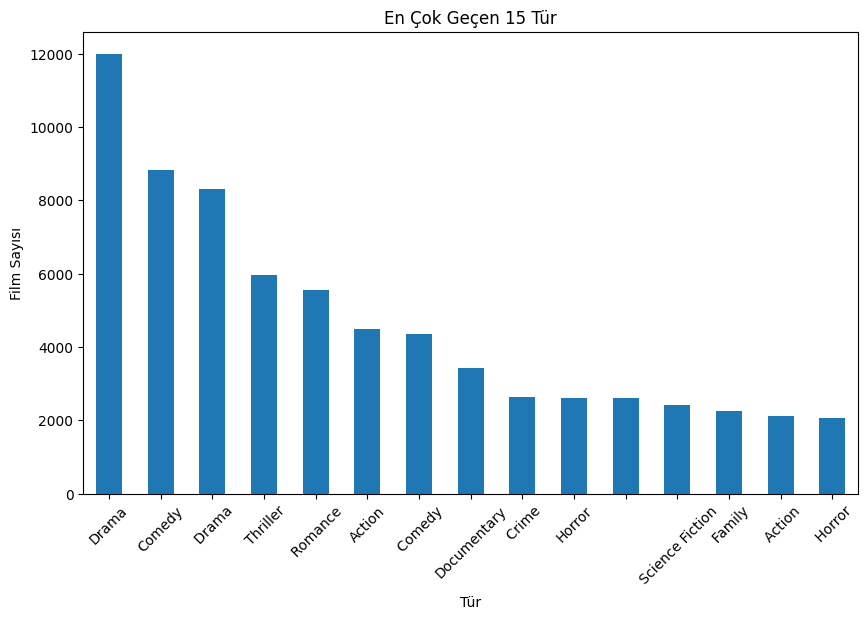

In [ ]:
import matplotlib.pyplot as plt

genre_counts = movie_details["genres_csv"].str.split(",").explode().value_counts().head(15)

plt.figure(figsize=(10,6))
genre_counts.plot(kind="bar")
plt.title("En Çok Geçen 15 Tür")
plt.xlabel("Tür")
plt.ylabel("Film Sayısı")
plt.xticks(rotation=45)
plt.show()

### **3. IMDb / TMDB Puan Dağılımı**

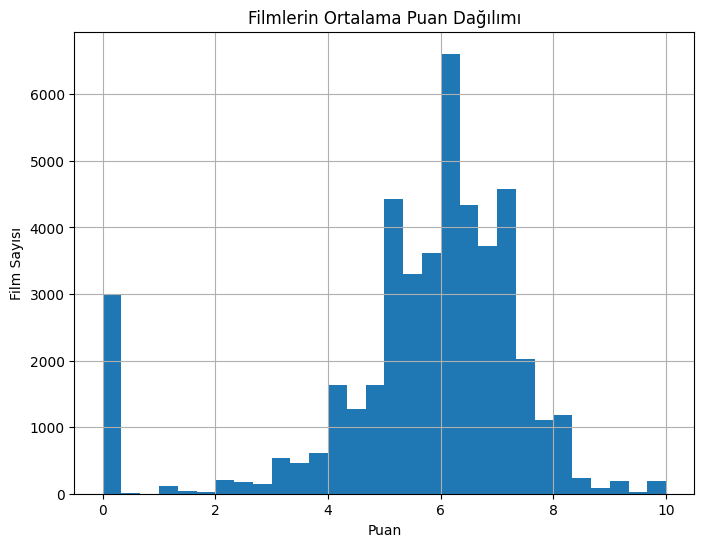

In [ ]:
plt.figure(figsize=(8,6))
movie_details["vote_average"].dropna().hist(bins=30)
plt.title("Filmlerin Ortalama Puan Dağılımı")
plt.xlabel("Puan")
plt.ylabel("Film Sayısı")
plt.show()


### **4. Oy Sayısı vs Ortalama Puan (Scatter Plot)**

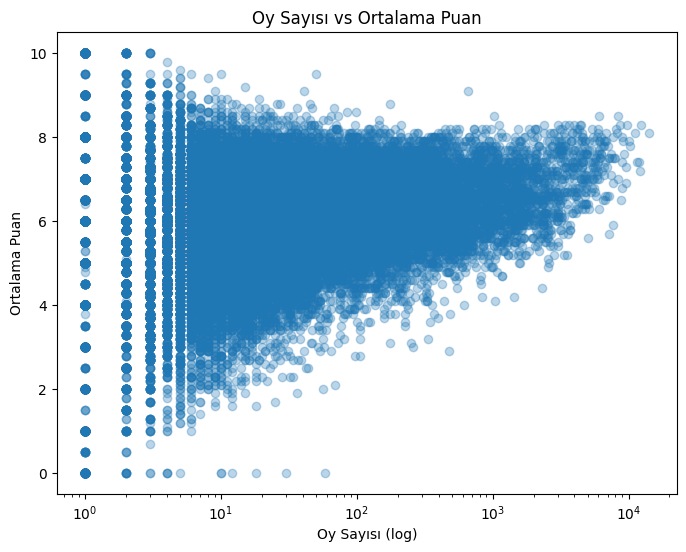

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(movie_details["vote_count"], movie_details["vote_average"], alpha=0.3)
plt.xscale("log")
plt.title("Oy Sayısı vs Ortalama Puan")
plt.xlabel("Oy Sayısı (log)")
plt.ylabel("Ortalama Puan")
plt.show()


### **5. ALS Faktörlerinin Dağılımı (Model tarafı)**

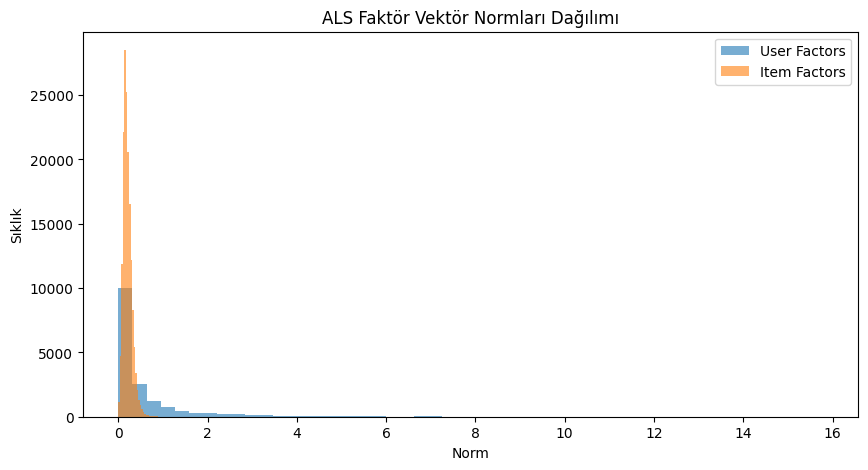

In [ ]:
user_norms = np.linalg.norm(als.user_factors, axis=1)
item_norms = np.linalg.norm(als.item_factors, axis=1)

plt.figure(figsize=(10,5))
plt.hist(user_norms, bins=50, alpha=0.6, label="User Factors")
plt.hist(item_norms, bins=50, alpha=0.6, label="Item Factors")
plt.title("ALS Faktör Vektör Normları Dağılımı")
plt.xlabel("Norm")
plt.ylabel("Sıklık")
plt.legend()
plt.show()


### **7. Kullanıcıların Ortalama Puan Eğilimleri (Ekstra - rating dataset kullanılırsa)**

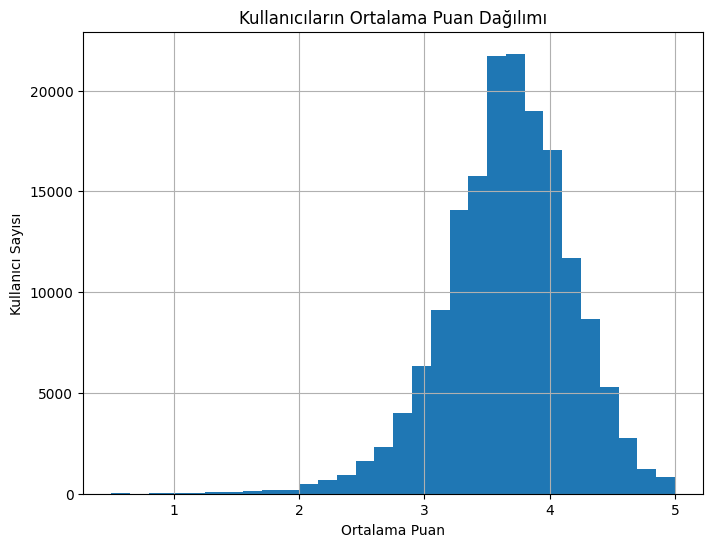

In [ ]:
plt.figure(figsize=(8,6))
ratings_df.groupby("userId")["rating"].mean().hist(bins=30)
plt.title("Kullanıcıların Ortalama Puan Dağılımı")
plt.xlabel("Ortalama Puan")
plt.ylabel("Kullanıcı Sayısı")
plt.show()


### **1. Film Faktörlerini 2D’ye İndirip Scatter Plot Çizmek (Örn. PCA / t-SNE)**

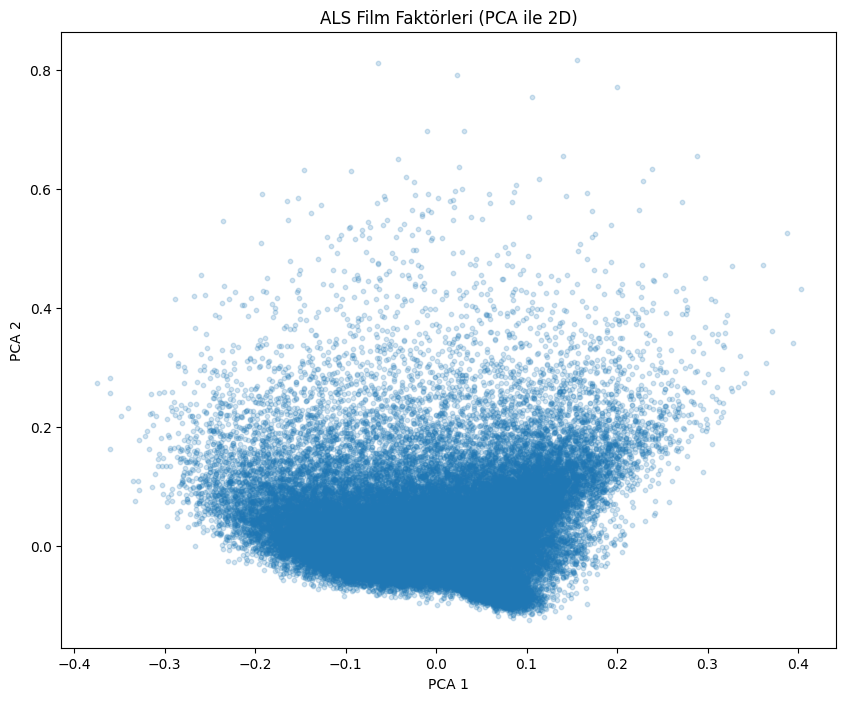

In [ ]:
from sklearn.decomposition import PCA

# Item faktörlerini indirgeme
pca = PCA(n_components=2)
item_2d = pca.fit_transform(als.item_factors)

plt.figure(figsize=(10,8))
plt.scatter(item_2d[:,0], item_2d[:,1], alpha=0.2, s=10)
plt.title("ALS Film Faktörleri (PCA ile 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


### **3. Kullanıcı Vektörünün Konumu (Ortalama Faktör Temsili)**

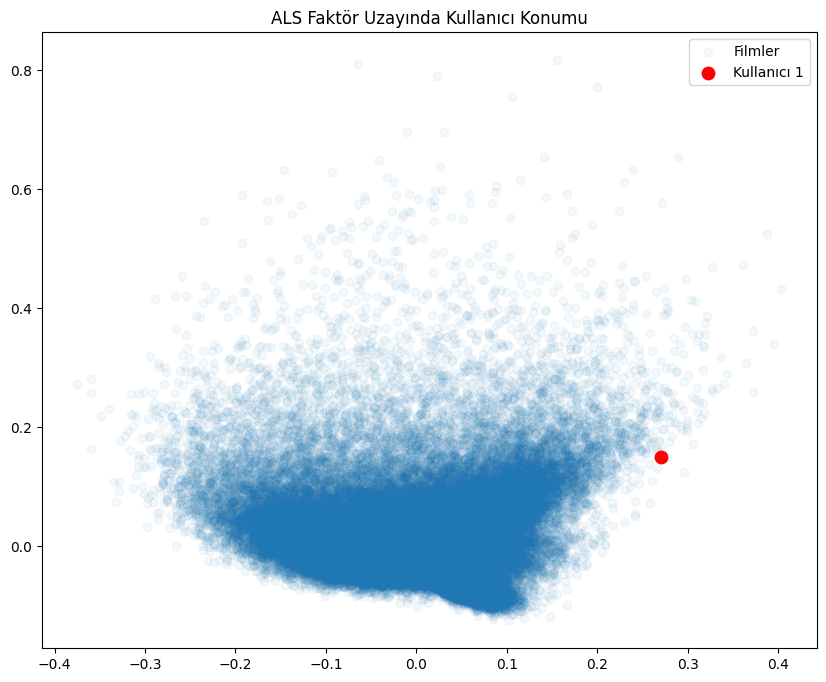

In [ ]:
uidx = uid_map[33]  # örnek kullanıcı
user_vec = als.user_factors[uidx]

# PCA ile aynı uzaya indir
uv2d = pca.transform(user_vec.reshape(1,-1))

plt.figure(figsize=(10,8))
plt.scatter(item_2d[:,0], item_2d[:,1], alpha=0.05, label="Filmler")
plt.scatter(uv2d[:,0], uv2d[:,1], color="red", s=80, label="Kullanıcı 1")
plt.legend()
plt.title("ALS Faktör Uzayında Kullanıcı Konumu")
plt.show()
